In [1]:
# !conda install -c conda-forge -y tensorflow 
# !conda install -c conda-forge -y keras
import tensorflow as tf # used for machine/deeplearning
import keras # used for machine/deeplearning
from keras import backend as K # used for creating custom functins
from keras.preprocessing.image import ImageDataGenerator, load_img # used for working with image data
import numpy as np # numerical python - used for converting images to arrays as well
import os # for working with local file directories
import pandas as pd # for working with data frames and series (in this case)
import matplotlib.pyplot as plt # for static plots

Using TensorFlow backend.


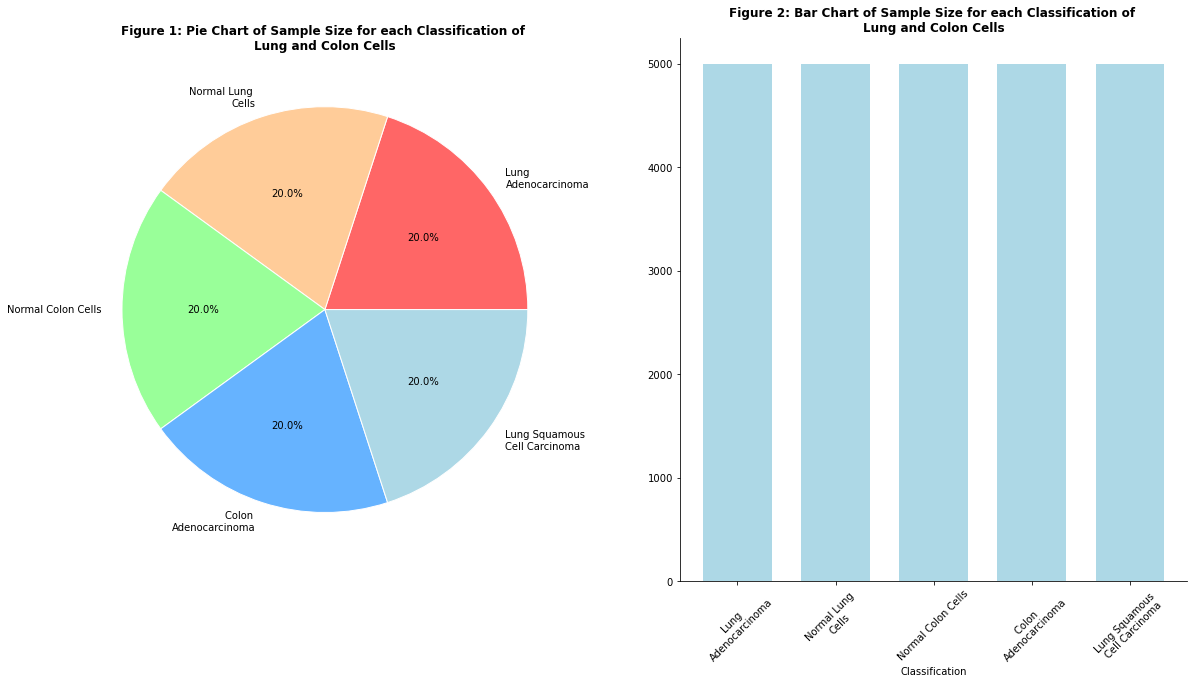

In [32]:
class_names = {"colon_n":"Normal Colon Cells","lung_n":"Normal Lung \nCells",
               "colon_aca":"Colon \nAdenocarcinoma",
               "lung_scc":"Lung Squamous \nCell Carcinoma",
               "lung_aca":"Lung \nAdenocarcinoma"}

# reads the class name as well as the number of files in the directory
class_sizes = pd.Series({class_names[subfolder]:len(os.listdir("Images/"+subfolder)) for subfolder in os.listdir("Images/")})

# the following produces bar and pie plots of the number of observations in each class
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff',"lightblue"]
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax1.pie(class_sizes.values,labels=class_sizes.index,autopct='%1.1f%%',colors=colors)
ax1.set_title(" ",fontweight='bold')

ax2.bar(class_sizes.index,class_sizes.values,width=.7,color="lightblue")
ax2.set_title("Figure 2: Bar Chart of Sample Size for each Classification of \nLung and Colon Cells",fontweight="bold")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.xticks(rotation=45)

# for manipulating the edgecolor of the pie chart
ax2.set_xlabel("Classification")
for patch in ax1.patches:
    patch.set_edgecolor('white')
    
# for displaying each plot:
plt.show()


### Data Reading and Preprocessing

In [81]:
# creates a mechanism to read from the directory into the current model. 
# Also performs feature engineering by converting an integer pixel intensity from
# 0 - 255 into a pixel intensity between 0 and 1:
datagen = ImageDataGenerator(rescale=1/255,validation_split=.2)

# reads the training data and validation image sets into their own data generators
training_generator = datagen.flow_from_directory('Images/', class_mode='categorical', batch_size=50,target_size=(150,150),subset="training")
validation_generator = datagen.flow_from_directory('Images/', class_mode='categorical', batch_size=50,target_size=(150,150),subset="validation")

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [91]:
class_indices=pd.Series(validation_generator.class_indices)
class_indices

colon_aca    0
colon_n      1
lung_aca     2
lung_n       3
lung_scc     4
dtype: int64

In [35]:

#  True Positives / True Positives /(True Positives + False Positives)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#  True Positives / True Positives /(True Positives + False Negatives)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
# 2 * precision * recall / (precision + recall)
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Multiple Logistic Regression Using the Keras API

In [36]:
from keras.models import Sequential # for initialiing the model
from keras.regularizers import L1L2 # for making an l2 model
from keras.layers import Dense,Dropout,Conv2D,Activation,MaxPooling2D,Flatten

model1 = Sequential() # initiates the model
model1.add(Flatten(input_shape=(150,150,3))) # takes a 150*150 image and flattens it to 22500 image
model1.add(Dense(5,activation='softmax', kernel_regularizer=L1L2(l1=0.0, l2=0.1))) # initiates the logistic regression

# compiles the model with the stochastic gradient descent optimizer and 3 metrics
model1.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

# fits and validates the model witht the training and validation set
model1.fit_generator(training_generator,steps_per_epoch=2000/50,epochs=50,
                    validation_data=validation_generator,validation_steps=800 / 50)


Epoch 1/50
40/40 [==============================] - 25s 628ms/step - loss: 125.4738 - accuracy: 0.2290 - f1_m: 0.2244 - precision_m: 0.2475 - recall_m: 0.2235 - val_loss: 160.7629 - val_accuracy: 0.1838 - val_f1_m: 0.1837 - val_precision_m: 0.1837 - val_recall_m: 0.1837
Epoch 2/50
40/40 [==============================] - 25s 618ms/step - loss: 106.0658 - accuracy: 0.2730 - f1_m: 0.2730 - precision_m: 0.2730 - recall_m: 0.2730 - val_loss: 132.5924 - val_accuracy: 0.1750 - val_f1_m: 0.1750 - val_precision_m: 0.1750 - val_recall_m: 0.1750
Epoch 3/50
40/40 [==============================] - 24s 595ms/step - loss: 94.7939 - accuracy: 0.3015 - f1_m: 0.3015 - precision_m: 0.3015 - recall_m: 0.3015 - val_loss: 81.3765 - val_accuracy: 0.3887 - val_f1_m: 0.3888 - val_precision_m: 0.3888 - val_recall_m: 0.3888
Epoch 4/50
40/40 [==============================] - 22s 560ms/step - loss: 84.6840 - accuracy: 0.2960 - f1_m: 0.2962 - precision_m: 0.2964 - recall_m: 0.2960 - val_loss: 96.0459 - val_accur

### Convolutional Neural Network Using the Keras API

In [37]:

model2 = Sequential() # starts the model specification process
model2.add(Conv2D(32, (3, 3), input_shape=(150,150,3))) # takes a 150*150 image, creates a convolutional layer
model2.add(Activation('relu')) # uses the relu activation function 
model2.add(MaxPooling2D(pool_size=(2, 2))) # aggregates via max pooling

# the following repeats the process 3 times over with varying numbers of units:
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model2.add(Dense(64)) # multiplies the incoming data by weights
model2.add(Activation('relu')) # performs the relu activation function
model2.add(Dropout(0.2)) # drops some neurons to minimize overfitting
model2.add(Dense(5)) # multiplies the input data by weights
# transforms the output into probabilities of each image belonging to a given class
model2.add(Activation('softmax')) 

# uses the adam optimizer and 3 metrics
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

# fits and validates the model witht the training and validation set
model2.fit_generator(training_generator,steps_per_epoch=2000/50,epochs=50,
                    validation_data=validation_generator,validation_steps=800 / 50)

Epoch 1/50
40/40 [==============================] - 40s 998ms/step - loss: 1.4001 - accuracy: 0.3535 - f1_m: 0.1273 - precision_m: 0.2828 - recall_m: 0.0950 - val_loss: 0.9038 - val_accuracy: 0.5337 - val_f1_m: 0.4198 - val_precision_m: 0.5883 - val_recall_m: 0.3300
Epoch 2/50
40/40 [==============================] - 38s 955ms/step - loss: 0.8592 - accuracy: 0.5960 - f1_m: 0.5237 - precision_m: 0.6522 - recall_m: 0.4465 - val_loss: 0.7975 - val_accuracy: 0.6725 - val_f1_m: 0.6094 - val_precision_m: 0.7089 - val_recall_m: 0.5362
Epoch 3/50
40/40 [==============================] - 39s 967ms/step - loss: 0.7774 - accuracy: 0.6380 - f1_m: 0.6014 - precision_m: 0.6691 - recall_m: 0.5490 - val_loss: 0.6216 - val_accuracy: 0.7300 - val_f1_m: 0.6768 - val_precision_m: 0.7696 - val_recall_m: 0.6050
Epoch 4/50
40/40 [==============================] - 39s 969ms/step - loss: 0.6634 - accuracy: 0.6820 - f1_m: 0.6621 - precision_m: 0.7072 - recall_m: 0.6240 - val_loss: 0.6386 - val_accuracy: 0.5800 

/home/sbr0/anaconda3/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 215 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/40 [==============================] - 319s 8s/step - loss: 0.3842 - accuracy: 0.8500 - f1_m: 0.8457 - precision_m: 0.8528 - recall_m: 0.8390 - val_loss: 0.3250 - val_accuracy: 0.8925 - val_f1_m: 0.8973 - val_precision_m: 0.9048 - val_recall_m: 0.8900
Epoch 16/50
40/40 [==============================] - 76s 2s/step - loss: 0.3608 - accuracy: 0.8530 - f1_m: 0.8523 - precision_m: 0.8609 - recall_m: 0.8440 - val_loss: 0.4888 - val_accuracy: 0.8700 - val_f1_m: 0.8704 - val_precision_m: 0.8747 - val_recall_m: 0.8662
Epoch 17/50
40/40 [==============================] - 201s 5s/step - loss: 0.3090 - accuracy: 0.8865 - f1_m: 0.8855 - precision_m: 0.8912 - recall_m: 0.8800 - val_loss: 0.3129 - val_accuracy: 0.8925 - val_f1_m: 0.8915 - val_precision_m: 0.8943 - val_recall_m: 0.8887
Epoch 18/50
40/40 [==============================] - 63s 2s/step - loss: 0.2974 - accuracy: 0.8825 - f1_m: 0.8817 - precision_m: 0.8865 - recall_m: 0.8770 - val_loss: 0.3124 - val_accuracy: 0.8775 - val_f1_m: 0.8776

Epoch 46/50
40/40 [==============================] - 40s 988ms/step - loss: 0.1657 - accuracy: 0.9360 - f1_m: 0.9341 - precision_m: 0.9358 - recall_m: 0.9325 - val_loss: 0.2747 - val_accuracy: 0.9237 - val_f1_m: 0.9260 - val_precision_m: 0.9296 - val_recall_m: 0.9225
Epoch 47/50
40/40 [==============================] - 39s 983ms/step - loss: 0.1686 - accuracy: 0.9365 - f1_m: 0.9364 - precision_m: 0.9383 - recall_m: 0.9345 - val_loss: 0.2040 - val_accuracy: 0.9438 - val_f1_m: 0.9443 - val_precision_m: 0.9461 - val_recall_m: 0.9425
Epoch 48/50
40/40 [==============================] - 40s 1s/step - loss: 0.1595 - accuracy: 0.9395 - f1_m: 0.9408 - precision_m: 0.9422 - recall_m: 0.9395 - val_loss: 0.0542 - val_accuracy: 0.9438 - val_f1_m: 0.9437 - val_precision_m: 0.9438 - val_recall_m: 0.9438
Epoch 49/50
40/40 [==============================] - 39s 987ms/step - loss: 0.1415 - accuracy: 0.9485 - f1_m: 0.9489 - precision_m: 0.9499 - recall_m: 0.9480 - val_loss: 0.0639 - val_accuracy: 0.9463

### Saving the models for future use:

In [38]:
model1.save("Multiple Logistic Model.h5")
model2.save("Convolutional Neural Net.h5")

### Using the model for prediction:

In [42]:
from keras.models import load_model
# loads the model
model2=load_model("Convolutional Neural Net.h5",custom_objects={"f1_m":f1_m,"precision_m":precision_m,
                                                                "recall_m":recall_m})


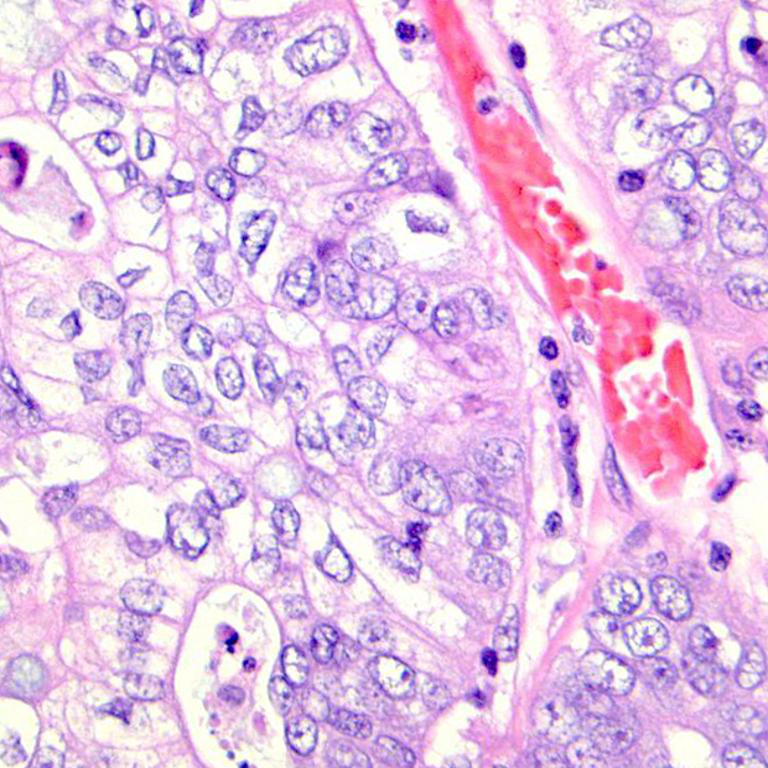

In [115]:
# displays a given image in the output
current_image="/home/sbr0/Dropbox/Analysis Planning/coursera stuffs/Capstone/Identification of Cancerous Cells/Images/colon_aca/colonca998.jpeg"
load_img(current_image)

In [93]:
# reads an image and displays it as a 150x150 array with intensities ranging from 0 - 1
# this is performed so that the image can be used for modeling
def image_as_array(img_path,target_size=(150,150)):
    test_image=np.asarray(load_img(current_image,target_size=target_size)) / 255
    return test_image

In [110]:
# The labels that the classes correspond to "class_indices" are as follows:
# colon_aca    0
# colon_n      1
# lung_aca     2
# lung_n       3
# lung_scc     4

# generates a class prediction and its associated probability for the inputted array
def predict_class(img_array,model=model2,class_indices=class_indicestsg):
    prediction_img_size=(1,img_array.shape[0],img_array.shape[1],img_array.shape[2])
    prediction_img_array = img_array.reshape(prediction_img_size)
    predicted_probabilities = model.predict(test_image.reshape((1,150,150,3)))
    probability=predicted_probabilities.max()
    idx=np.argmax(predicted_probabilities)
    predicted_class = class_indices.loc[class_indices==idx].index[0]
    return predicted_class,probability
    

### Prediction Demo

In [113]:
test = image_as_array(current_image)
predict_class(test)

('colon_aca', 0.97943443)